# Statistical Analysis 

Analyzing the significance of the differences between the modified Still Face Paradigm conditions.

In [152]:
import json 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from hypyp import stats 
import seaborn as sns
from statannot import add_stat_annotation
import scikit_posthocs as sp
import pandas as pd
from ordered_set import OrderedSet

# Infant Alpha band (6-9 Hz) analysis

In [153]:
f = open("validated_results_alpha_plv.json")

# returns JSON object as 
# a dictionary
results = json.load(f)
  
# Iterating through the json
# list
fp1_alpha = []
sf1_alpha = []
fp2_alpha = []
sf2_alpha = []
ru_alpha = []

all_stages = [fp1_alpha, sf1_alpha, fp2_alpha, sf2_alpha, ru_alpha]
participant_indices = []
for part, stages in results.items():
    if part == '623' or part == '802':
        continue
    else:
        for stage, data in stages.items():
            stage = int(stage[1]) - 1
            all_stages[stage].append(np.nanmean(data))
        participant_indices.append(part)

participant_indices = np.array(OrderedSet(participant_indices))

sf2_alpha = [0 if str(x) == 'nan' else x for x in sf2_alpha]

for i in all_stages:
    print(len(i))
data_alpha = [np.array(fp1_alpha), np.array(sf1_alpha), np.array(fp2_alpha), np.array(sf2_alpha), np.array(ru_alpha)] 

33
33
33
33
33


In [154]:
import csv
data_alpha = np.column_stack((participant_indices, fp1_alpha, sf1_alpha, fp2_alpha, sf2_alpha, ru_alpha))

# Define the column names
column_names = ["participant", "fp1", "sf1", "fp2", "sf2", "reunion"]

# Define the filename for the CSV file
filename = "validated_data_alpha_plv.csv"

with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    writer.writerow(column_names)

    writer.writerows(data_alpha)

### Descriptive analysis

In [155]:
descriptives = {'Mean': [],
                'SD': [],
                'Min': [],
                'Max': []}

for condition in all_stages: 
    descriptives['Mean'].append(round(np.mean(condition), 4))
    descriptives['SD'].append(round(np.std(condition), 4))
    descriptives['Min'].append(round(np.min(condition), 4))
    descriptives['Max'].append(round(np.max(condition), 4))

descriptives_df = pd.DataFrame(descriptives)
descriptives_df.insert(0, 'Condition', ['Free Play 1', 'Still Face 1', 'Free Play 2',
                                        'Still Face 2', 'Reunion'])

descriptives_df.to_latex('synchrony_descriptives_alpha.tex')
descriptives_df

/tmp/ipykernel_6637/1220507243.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  descriptives_df.to_latex('synchrony_descriptives_alpha.tex')


,Condition,Mean,SD,Min,Max
0,Free Play 1,0.4901,0.0165,0.4583,0.5302
1,Still Face 1,0.4841,0.0188,0.4333,0.5419
2,Free Play 2,0.4875,0.0197,0.4613,0.5565
3,Still Face 2,0.4863,0.0215,0.4388,0.5399
4,Reunion,0.4882,0.0164,0.4588,0.5356


# Test Normality of Distribution

In [156]:
import pandas as pd
import pingouin as pg
from scipy.stats import shapiro

# Load data
df = pd.DataFrame({"FreePlay1": fp1_alpha,
                  "StillFace1": sf1_alpha,
                  "FreePlay2": fp2_alpha,
                  "StillFace2": sf2_alpha,
                  'Reunion': ru_alpha
                  })


# Create a multi-indexed dataframe
df_melted_alpha = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['FreePlay1', 'StillFace1', 'FreePlay2', 'StillFace2', 'Reunion'])

# Rename columns
df_melted_alpha.columns = ['id', 'Condition', 'Synchrony']

# grouped = df_melted.groupby(["condition"])

data = np.random.normal(0, 1, 100)
stat, p = shapiro(df_melted_alpha["Synchrony"])

print("Test statistic:", stat)
if p > 0.05:
    print("p = ", p, "-> data is normally distributed")
else:
    print("p-value = ", p, "-> data is non-normally distributed")

Test statistic: 0.9631109237670898
p-value =  0.00022770768555346876 -> data is non-normally distributed


# Fisher Z Transform

In [157]:
# Perform the Fisher z-transform
z_fp1_alpha = np.arctanh(fp1_alpha)
z_sf1_alpha = np.arctanh(sf1_alpha)
z_fp2_alpha = np.arctanh(fp2_alpha)
z_sf2_alpha = np.arctanh(sf2_alpha)
z_ru_alpha = np.arctanh(ru_alpha)

# Load data
df = pd.DataFrame({"FreePlay1": z_fp1_alpha,
                  "StillFace1": z_sf1_alpha,
                  "FreePlay2": z_fp2_alpha,
                  "StillFace2": z_sf2_alpha,
                  'Reunion': z_ru_alpha
                  })


# Create a multi-indexed dataframe
df_melted_z = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['FreePlay1', 'StillFace1', 'FreePlay2', 'StillFace2', 'Reunion'])

# Rename columns
df_melted_z.columns = ['id', 'Condition', 'Synchrony']

data = np.random.normal(0, 1, 100)
stat, p = shapiro(df_melted_z["Synchrony"])

print("Test statistic:", stat)
if p > 0.05:
    print("p = ", p, "-> data is normally distributed")
else:
    print("p-value = ", p, "-> data is non-normally distributed")

Test statistic: 0.956810474395752
p-value =  5.555658935918473e-05 -> data is non-normally distributed


### The distribution is still not normal -> non-parametric one-way ANOVA -> Friedman Test

## Main Effect: Friedman Test
The null hypothesis (H0): The mean for each population is equal.

The alternative hypothesis: (Ha): At least one population mean is different from the rest.

https://www.statology.org/friedman-test-python/

In [158]:
pg.friedman(data=df_melted_alpha, dv='Synchrony', within='Condition', subject = 'id', method = 'chisq')

,Source,W,ddof1,Q,p-unc
Friedman,Condition,0.024059,4,3.175758,0.528855


## Post Hoc Analysis: Wilcoxon Signed-Rank Test 

In [159]:
import numpy as np
from scipy import stats
import scikit_posthocs as sp

# Perform Wilcoxon signed-rank test and compute z-values
def get_z_values(data, groups):
    z_values = np.zeros((len(groups), len(groups)))

    for i, group1 in enumerate(groups):
        for j, group2 in enumerate(groups):
            if j >= i:
                continue
            x = data[data['Condition'] == group1]['Synchrony']
            y = data[data['Condition'] == group2]['Synchrony']
            result = stats.wilcoxon(x, y)
            z_values[i, j] = result.statistic
            z_values[j, i] = -result.statistic

    return z_values

# Perform post-hoc test and adjustment
posthoc_result_alpha = sp.posthoc_wilcoxon(a=df_melted_alpha, val_col="Synchrony", group_col="Condition", p_adjust='fdr_tsbky')

# Compute z-values
z_values_alpha = get_z_values(df_melted_alpha, posthoc_result_alpha.index)

print("Post-hoc test result:")
print(posthoc_result_alpha)
print("Z-values:")
print(z_values_alpha)


Post-hoc test result:
            FreePlay1  StillFace1  FreePlay2  StillFace2   Reunion
FreePlay1    1.000000    0.423808   0.423808    0.423808  0.876414
StillFace1   0.423808    1.000000   0.876414    0.876414  0.843868
FreePlay2    0.423808    0.876414   1.000000    0.903071  0.903071
StillFace2   0.423808    0.876414   0.903071    1.000000  0.903071
Reunion      0.876414    0.843868   0.903071    0.903071  1.000000
Z-values:
[[   0. -182. -190. -193. -237.]
 [ 182.    0. -246. -249. -224.]
 [ 190.  246.    0. -270. -265.]
 [ 193.  249.  270.    0. -265.]
 [ 237.  224.  265.  265.    0.]]


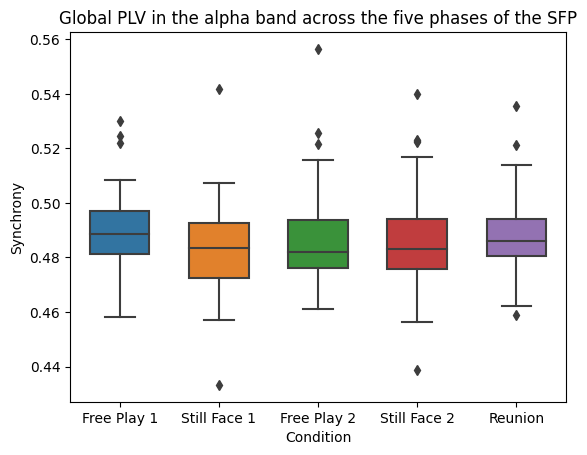

In [160]:
ax = sns.boxplot(data = df_melted_alpha, x = 'Condition', y = 'Synchrony', width = 0.6)
ax.set_title('Global PLV in the alpha band across the five phases of the SFP')
ax.set_xticklabels(['Free Play 1', 'Still Face 1', 'Free Play 2', 'Still Face 2', 'Reunion'])

ax.figure.savefig("alpha_results_plv.png") 

# Infant Theta Band (3-5 Hz) Analysis

In [161]:
# f = open('results_theta_plv.json')
f = open("validated_results_theta_plv.json")

# returns JSON object as 
# a dictionary
results = json.load(f)
  
# Iterating through the json
# list
fp1_theta = []
sf1_theta = []
fp2_theta = []
sf2_theta = []
ru_theta = []

all_stages = [fp1_theta, sf1_theta, fp2_theta, sf2_theta, ru_theta]
for part, stages in results.items():
    if part == '623' or part == '802':
        continue
    else:
        for stage, data in stages.items():
            stage = int(stage[1]) - 1
            all_stages[stage].append(np.nanmean(data))

sf2_theta = [0 if str(x) == 'nan' else x for x in sf2_theta]

data_theta = [fp1_theta, sf1_theta, fp2_theta, sf2_theta, ru_theta] 
data_theta = [np.array(x) for x in data_theta]

f.close()

In [162]:
data_theta = np.column_stack((participant_indices, fp1_theta, sf1_theta, fp2_theta, sf2_theta, ru_theta))

# Define the column names
column_names = ["participant", "fp1", "sf1", "fp2", "sf2", "reunion"]

# Define the filename for the CSV file
filename = "validated_data_theta_plv.csv"

with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    writer.writerow(column_names)

    writer.writerows(data_theta)

## Descriptive Statistics

In [163]:
descriptives = {'Mean': [],
                'SD': [],
                'Min': [],
                'Max': []}

for condition in all_stages: 
    descriptives['Mean'].append(round(np.mean(condition), 4))
    descriptives['SD'].append(round(np.std(condition), 4))
    descriptives['Min'].append(round(np.min(condition), 4))
    descriptives['Max'].append(round(np.max(condition), 4))

descriptives_df = pd.DataFrame(descriptives)
descriptives_df.insert(0, 'Condition', ['Free Play 1', 'Still Face 1', 'Free Play 2',
                                        'Still Face 2', 'Reunion'])

descriptives_df.to_latex('synchrony_descriptives_theta.tex')
descriptives_df

/tmp/ipykernel_6637/222204992.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  descriptives_df.to_latex('synchrony_descriptives_theta.tex')


,Condition,Mean,SD,Min,Max
0,Free Play 1,0.5621,0.0221,0.5169,0.6096
1,Still Face 1,0.5456,0.0192,0.5171,0.6229
2,Free Play 2,0.5556,0.0178,0.5200,0.5960
3,Still Face 2,0.5512,0.0292,0.5024,0.6445
4,Reunion,0.5614,0.0188,0.5222,0.6208


In [164]:
# Load data
df = pd.DataFrame({"FreePlay1": fp1_theta,
                  "StillFace1": sf1_theta,
                  "FreePlay2": fp2_theta,
                  "StillFace2": sf2_theta,
                  'Reunion': ru_theta
                  })


# Create a multi-indexed dataframe
df_melted_theta = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['FreePlay1', 'StillFace1', 'FreePlay2', 'StillFace2', 'Reunion'])

# Rename columns
df_melted_theta.columns = ['id', 'Condition', 'Synchrony']

stat, p = shapiro(df_melted_theta["Synchrony"])

print("Test statistic:", stat)
if p > 0.05:
    print("p = ", p, "-> data is normally distributed")
else:
    print("p-value = ", p, "-> data is non-normally distributed")

Test statistic: 0.9556348323822021
p-value =  4.316076228860766e-05 -> data is non-normally distributed


## Fisher Z-Transform

In [165]:
# Perform the Fisher z-transform
z_fp1_theta = np.arctanh(fp1_theta)
z_sf1_theta = np.arctanh(sf1_theta)
z_fp2_theta = np.arctanh(fp2_theta)
z_sf2_theta = np.arctanh(sf1_theta)
z_ru_theta = np.arctanh(ru_theta)

# Load data
df = pd.DataFrame({"FreePlay1": z_fp1_theta,
                  "StillFace1": z_sf1_theta,
                  "FreePlay2": z_fp2_theta,
                  "StillFace2": z_sf2_theta,
                  'Reunion': z_ru_theta
                  })


# Create a multi-indexed dataframe
df_melted_z = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['FreePlay1', 'StillFace1', 'FreePlay2', 'StillFace2', 'Reunion'])

# Rename columns
df_melted_z.columns = ['id', 'Condition', 'Synchrony']

data = np.random.normal(0, 1, 100)
stat, p = shapiro(df_melted_z["Synchrony"])

print("Test statistic:", stat)
if p > 0.05:
    print("p = ", p, "-> data is normally distributed")
else:
    print("p-value = ", p, "-> data is non-normally distributed")

Test statistic: 0.9395938515663147
p-value =  1.8344593399888254e-06 -> data is non-normally distributed


## Main Effect: Friedman Test

In [166]:
# Perform Friedman test
pg.friedman(data=df_melted_theta, dv='Synchrony', within='Condition', subject = 'id', method = 'chisq')

,Source,W,ddof1,Q,p-unc
Friedman,Condition,0.24775,4,32.70303,0.000001


## Post Hoc: Wilcoxon Signed-Rank Test

In [167]:
# Perform post-hoc test and adjustment
posthoc_result_theta = sp.posthoc_wilcoxon(a=df_melted_theta, val_col="Synchrony", group_col="Condition", p_adjust='fdr_tsbky')

# Compute z-values
z_values_theta = get_z_values(df_melted_theta, posthoc_result_theta.index)

print("Post-hoc test result:")
print(posthoc_result_theta)
print("Z-values:")
print(z_values_theta)

Post-hoc test result:
            FreePlay1  StillFace1  FreePlay2  StillFace2   Reunion
FreePlay1    1.000000    0.000059   0.061243    0.007759  0.480779
StillFace1   0.000059    1.000000   0.000052    0.113638  0.000052
FreePlay2    0.061243    0.000052   1.000000    0.053092  0.046217
StillFace2   0.007759    0.113638   0.053092    1.000000  0.005281
Reunion      0.480779    0.000052   0.046217    0.005281  1.000000
Z-values:
[[   0.  -64. -186. -133. -274.]
 [  64.    0.  -59. -207.  -59.]
 [ 186.   59.    0. -179. -172.]
 [ 133.  207.  179.    0. -123.]
 [ 274.   59.  172.  123.    0.]]


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04



FreePlay1 v.s. StillFace1: Custom statistical test, P_val:5.900e-05
StillFace1 v.s. FreePlay2: Custom statistical test, P_val:5.200e-05
StillFace2 v.s. Reunion: Custom statistical test, P_val:5.281e-03
FreePlay2 v.s. Reunion: Custom statistical test, P_val:4.622e-02
FreePlay1 v.s. StillFace2: Custom statistical test, P_val:7.759e-03
StillFace1 v.s. Reunion: Custom statistical test, P_val:5.200e-05


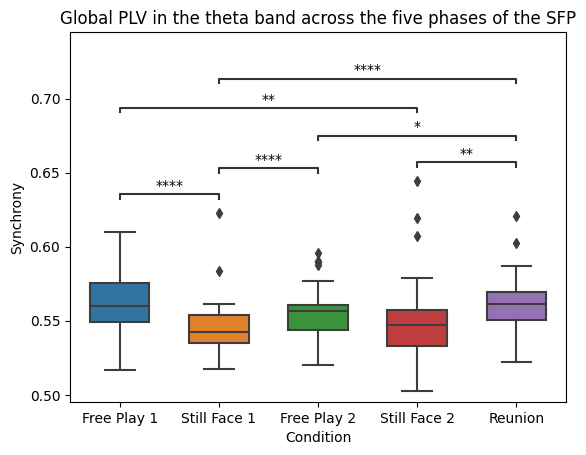

In [168]:
ax = sns.boxplot(data = df_melted_theta, x = 'Condition', y = 'Synchrony', width = 0.6)
ax.set_title('Global PLV in the theta band across the five phases of the SFP')
ax.set_xticklabels(['Free Play 1', 'Still Face 1', 'Free Play 2', 'Still Face 2', 'Reunion'])
# ax.set(ylim=(0.3, 0.55))
add_stat_annotation(ax, data = df_melted_theta, x = 'Condition', y = 'Synchrony', 
                    box_pairs = [('FreePlay1', 'StillFace1'), ("FreePlay1", "StillFace2"), ('StillFace1', 'FreePlay2'),
                                 ('StillFace1', 'Reunion'), ("FreePlay2", "Reunion"), ('StillFace2', 'Reunion')
                                 ],
                    perform_stat_test=False,
                    pvalues=[0.000059, 0.007759, 0.000052, 0.000052, 0.046217, 0.005281],
                    text_format = 'star',
)

ax.figure.savefig("theta_results_plv.png") 

## Calculating the % of the data kept after validation

In [169]:
with open("validated_results_alpha_plv.json") as f:
    results_theta = json.load(f)

# print(np.array(results_theta['029']['-1-']))

# np.count_nonzero(~np.isnan(np.array(results_theta['036']['-1-']))) # 665
epochs = 0
percent_kept = [0, 0, 0, 0, 0]
for part, stages in results_theta.items():
    for stage, data in stages.items():
        stage = int(stage[1]) - 1
        epochs += np.array(data).shape[0]
        nan_count = np.count_nonzero(np.isnan(np.array(data)))
        nonnan_count = np.count_nonzero(~np.isnan(np.array(data)))
        percent_kept[stage - 1] = nonnan_count/(nonnan_count+nan_count)
            
    
print(np.mean(percent_kept))

0.26915509259259257


In [170]:
import json
import numpy as np

with open("validated_results_theta_plv.json") as f:
    results_theta = json.load(f)

# print(np.array(results_theta['029']['-1-']))

# np.count_nonzero(~np.isnan(np.array(results_theta['036']['-1-']))) # 665
epochs = 0
percent_kept = [0, 0, 0, 0, 0]
for part, stages in results_theta.items():
    for stage, data in stages.items():
        stage = int(stage[1]) - 1
        epochs += np.array(data).shape[0]
        nan_count = np.count_nonzero(np.isnan(np.array(data)))
        nonnan_count = np.count_nonzero(~np.isnan(np.array(data)))
        percent_kept[stage - 1] = nonnan_count/(nonnan_count+nan_count)
            
    
print(np.mean(percent_kept))

0.23466435185185186
